In [123]:
from ugropy import unifac, Groups, FragmentationModel

import numpy as np

from rdkit import Chem

from itertools import combinations, product, chain

from numba import njit, jit


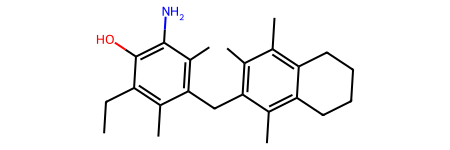

In [2]:
groups = Groups("C13=C(C(=C(C(=C1C)C)CC2=C(C(=C(C(=C2C)CC)O[H])N([H])[H])C)C)CCCC3", "smiles")

groups.chem_object

In [3]:
groups.unifac_groups

{'CH3': 1, 'CH2': 2, 'ACCH3': 5, 'ACCH2': 4, 'ACOH': 1, 'ACNH2': 1, 'AC': 1}

In [149]:
def fit_atoms(mol_object: Chem.rdchem.Mol, mol_subgroups: dict, model: FragmentationModel):
    # =========================================================================
    # Number of atoms in mol_object
    # =========================================================================
    total_atom_num = mol_object.GetNumAtoms()

    # =========================================================================
    # Getting true smarts, this will not be necessary later 
    # =========================================================================    
    smarts = {}
    for group in mol_subgroups.keys():
        s = model.subgroups.loc[group, "true_smarts"]

        if s is np.nan:
            s = model.subgroups.loc[group, "smarts"]

        smarts.update({group: s})

    # =========================================================================
    # Getting atoms candidates for each group
    # =========================================================================
    groups_atoms = {}
    for group, smt in smarts.items():
        atom = mol_object.GetSubstructMatches(Chem.MolFromSmarts(smt))
        groups_atoms[group] = atom

    # =========================================================================
    # Getting combinations for each subgroup according to the number of the
    # number of occurences in the mol_subgroups tentative solution.
    # =========================================================================
    atoms_combinations = {group: list(combinations(groups_atoms[group], mol_subgroups[group])) for group in mol_subgroups}

    # Combination of possible solutions
    llaves = list(atoms_combinations.keys())
    #tuplas_externas = [atoms_combinations[key] for key in llaves]

    # Generar todas las combinaciones posibles
    for combinacion in product(*atoms_combinations.values()):
        array_plano = chain(*chain(*combinacion))

        if len(set(array_plano)) == total_atom_num:
            sol_comb_dict = {llaves[i]: combinacion[i][0] if len(combinacion[i]) == 1 else combinacion[i] for i in range(len(llaves))}
            return sol_comb_dict

    return {}



In [150]:
atoms = fit_atoms(groups.chem_object, groups.unifac_groups, unifac)

atoms

{'CH3': (17,),
 'CH2': ((23,), (24,)),
 'ACCH3': ((2, 21), (4, 7), (5, 6), (10, 20), (14, 15)),
 'ACCH2': ((0, 25), (1, 22), (3, 8), (13, 16)),
 'ACOH': (12, 18),
 'ACNH2': (11, 19),
 'AC': (9,)}

In [113]:
atoms = fit_atoms(groups.chem_object, groups.unifac_groups, unifac)

atoms

{'CH3': (17,),
 'CH2': ((23,), (24,)),
 'ACCH3': ((2, 21), (4, 7), (5, 6), (10, 20), (14, 15)),
 'ACCH2': ((0, 25), (1, 22), (3, 8), (13, 16)),
 'ACOH': (12, 18),
 'ACNH2': (11, 19),
 'AC': (9,)}

In [133]:
comb = (((6,),), ((8,), (16,)), ((2, 21), (4, 7), (5, 6), (10, 20), (14, 15)), ((0, 25), (1, 22), (3, 8), (9, 8)), ((12, 18),), ((11, 19),), ((0,),))

In [151]:
%%timeit
atoms = fit_atoms(groups.chem_object, groups.unifac_groups, unifac)

atoms

6.51 ms ± 683 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [142]:
1 * 3438 / (6.01 / 1000)

572046.5890183029

In [146]:
np.log(572046.5890183029) / np.log(3)

12.067019323486505

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

# http://rdkit.blogspot.com/2015/02/new-drawing-code.html

def moltosvg(mol,molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc, highlightAtoms=np.array(atoms["ACH"]).flatten().tolist()) # highlightAtoms=[6,12,13]) you can highlight atoms
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

SVG(moltosvg(groups.chem_object))


KeyError: 'ACH'